# Weighted time series forecasting

In many real-world scenarios, historical data is available for forecasting, but not all of it is reliable. For example, IoT sensors capture raw data from the physical world, but they are often prone to failure, malfunction, and attrition due to harsh deployment environments, leading to unusual or erroneous readings. Similarly, factories may shut down for maintenance, repair, or overhaul, resulting in gaps in the data. The Covid-19 pandemic has also affected population behavior, impacting many time series such as production, sales, and transportation.

The presence of unreliable or unrepresentative values in the data history poses a significant challenge, as it hinders model learning. However, most forecasting algorithms require complete time series data, making it impossible to remove these observations. An alternative solution is to reduce the weight of the affected observations during model training. This document demonstrates how **skforecast** makes it easy to implement this strategy with two examples.

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(0,184,212,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px;
border-left: 8px solid #00b8d4; border-color: #00b8d4; padding-left: 10px;">
<p class="title">
    <i class="fa-light fa-pencil fa" style="font-size: 18px; color:#00b8d4;"></i>
    <b> &nbsp Note</b>
</p>

The examples that follow demonstrate how a portion of the time series can be excluded from model training by assigning it a weight of zero. However, the use of weights extends beyond the inclusion or exclusion of observations and can also balance the degree of influence that each observation has on the forecasting model. For instance, an observation assigned a weight of 10 will have ten times more impact on the model training than an observation assigned a weight of 1.

</div>

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

In most gradient boosting implementations, such as LightGBM, XGBoost, and CatBoost, samples with zero weight are typically excluded when calculating gradients and Hessians. However, these samples are still taken into account when constructing the feature histograms, which can result in a model that differs from one trained without zero-weighted samples. For more information on this issue, please refer to <a href="https://github.com/microsoft/LightGBM/issues/5553">this GitHub issue</a>.

</div>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-darkgrid')
from sklearn.linear_model import Ridge
from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.model_selection import backtesting_forecaster

## Data

Power plants used for energy generation are complex installations that require a high level of maintenance. It is typical for power plants to require periodic shutdowns for maintenance, repair, or overhaul activities. The following data set simulates these events, where energy production experiences a decrease.

In [2]:
# Data download
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/'
       'data/energy_production_shutdown.csv')
data = pd.read_csv(url, sep=',')

# Data preprocessing
# ==============================================================================
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data = data.set_index('date')
data = data.asfreq('D')
data = data.sort_index()
data.head()

,production
date,
2012-01-01,375.1
2012-01-02,474.5
2012-01-03,573.9
2012-01-04,539.5
2012-01-05,445.4


In [3]:
# Split data into train-val-test
# ==============================================================================
data = data.loc['2012-01-01 00:00:00': '2014-12-30 23:00:00']
end_train = '2013-12-31 23:59:00'
data_train = data.loc[: end_train, :]
data_test  = data.loc[end_train:, :]

print(
    f"Dates train : {data_train.index.min()} --- {data_train.index.max()}   "
    f"(n={len(data_train)})"
)
print(
    f"Dates test  : {data_test.index.min()} --- {data_test.index.max()}   "
    f"(n={len(data_test)})"
)

Dates train : 2012-01-01 00:00:00 --- 2013-12-31 00:00:00   (n=731)
Dates test  : 2014-01-01 00:00:00 --- 2014-12-30 00:00:00   (n=364)


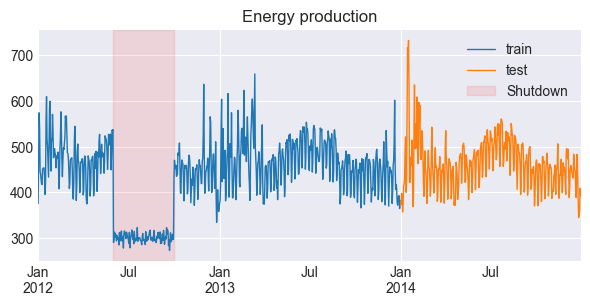

In [4]:
# Time series plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_train.production.plot(ax=ax, label='train', linewidth=1)
data_test.production.plot(ax=ax, label='test', linewidth=1)
ax.axvspan(
    pd.to_datetime('2012-06'),
    pd.to_datetime('2012-10'), 
    label="Shutdown",
    color="red",
    alpha=0.1
)
ax.set_title('Energy production')
ax.set_xlabel("")
ax.legend();

## Exclude part of the time series

Between 2012-06-01 and 2012-09-30, the factory underwent a shutdown. To reduce the impact of these dates on the model, a custom function is created. This function assigns a value of 0 to any index date that falls within the shutdown period or up to 21 days later (lags used by the model), and a value of 1 to all other dates. Observations assigned a weight of 0 have no influence on the model training.

In [5]:
# Custom function to create weights
# ==============================================================================
def custom_weights(index):
    """
    Return 0 if index is between 2012-06-01 and 2012-10-21.
    """
    weights = np.where(
                  (index >= '2012-06-01') & (index <= '2012-10-21'),
                   0,
                   1
              )

    return weights

A `ForecasterAutoreg` is trained including the `custom_weights` function.

In [6]:
# Create a recursive multi-step forecaster (ForecasterAutoreg)
# ==============================================================================
forecaster = ForecasterAutoreg(
                 regressor   = Ridge(random_state=123),
                 lags        = 21,
                 weight_func = custom_weights
             )

<script src="https://kit.fontawesome.com/d20edc211b.js" crossorigin="anonymous"></script>
<div class="admonition note" name="html-admonition" style="background: rgba(255,145,0,.1); padding-top: 0px; padding-bottom: 6px; border-radius: 8px; border-left: 8px solid #ff9100; border-color: #ff9100; padding-left: 10px;">
<p class="title">
    <i class="fa-triangle-exclamation fa" style="font-size: 18px; color:#ff9100;"></i>
    <b style="color: #ff9100;"> &nbsp Warning</b>
</p>

If the regressor used in the model's fitting method does not support <code>sample_weight</code> within its <code>fit</code> method, the <code>weight_func</code> argument will be ignored.

</div>

The `source_code_weight_func` argument stores the source code of the `weight_func` added to the forecaster.

In [7]:
print(forecaster.source_code_weight_func)

def custom_weights(index):
    """
    Return 0 if index is between 2012-06-01 and 2012-10-21.
    """
    weights = np.where(
                  (index >= '2012-06-01') & (index <= '2012-10-21'),
                   0,
                   1
              )

    return weights



After creating the forecaster, a [backtesting process](https://skforecast.org/latest/user_guides/backtesting.html) is performed to simulate its behavior if the test set had been predicted in batches of 12 days.

In [8]:
# Backtesting: predict batches of 12 days
# ==============================================================================
metric, predictions_backtest = backtesting_forecaster(
                                   forecaster         = forecaster,
                                   y                  = data.production,
                                   initial_train_size = len(data.loc[:end_train]),
                                   fixed_train_size   = False,
                                   steps              = 12,
                                   metric             = 'mean_absolute_error',
                                   refit              = False,
                                   verbose            = False,
                                   show_progress      = True
                               )

print(f"Backtest error: {metric}")
predictions_backtest.head()

  0%|          | 0/31 [00:00<?, ?it/s]

Backtest error: 26.821189403467972


,pred
2014-01-01,406.122211
2014-01-02,444.103631
2014-01-03,469.424876
2014-01-04,449.407001
2014-01-05,414.945674


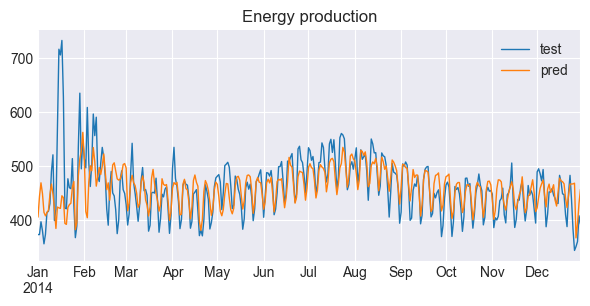

In [9]:
# Predictions plot
# ==============================================================================
fig, ax = plt.subplots(figsize=(7, 3))
data_test.production.plot(ax=ax, label='test', linewidth=1)
predictions_backtest.plot(ax=ax, label='predictions', linewidth=1)
ax.set_title('Energy production')
ax.set_xlabel("")
ax.legend();